In [1]:
import torch
import torchvision
import glob
import cv2
import PIL
import time
import matplotlib.pyplot as plt
from unet import UNet
import imutils
import pytorch_ssim
import numpy as np
import tqdm
from IPython.display import HTML, display, clear_output
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from timm.scheduler import CosineLRScheduler
import MyUtil


In [2]:
# データセット設定
class dataset_faces(torch.utils.data.Dataset):
    def __init__(self, fileName, transform_main=None):
        self.transform_main = transform_main

        self.fileName = fileName
        self.fileList = glob.glob(fileName + "/*")

    def __len__(self):
        output = len(self.fileList)
        return output

    def __getitem__(self, idx):
        img = self.my_imread(self.fileList[idx])
        img = self.transform_main(img)
        return self.linedraw(img), img

    def my_imread(self, filename):
        try:
            img = cv2.imdecode(np.fromfile(filename, np.uint8), cv2.IMREAD_COLOR)
            return img[:, :, ::-1]
        except Exception as e:
            print(e)
            return None

    def linedraw(self, x):
        transform = torchvision.transforms.Grayscale(3)
        x = transform(x)
        # 3x3カーネルで膨張1回（膨張はMaxPoolと同じ）
        dilated = torch.max_pool2d(x, kernel_size=3, stride=1, padding=1)
        # 膨張の前後でL1の差分を取る
        diff = torch.abs(x - dilated)
        # ネガポジ反転
        x = 1.0 - diff
        return x


In [3]:
# 割り込み停止検知（KeyboardInterruptで保存）
def SaveOnKI(funk):
    def _inner(*args):
        try:
            funk(*args)
        except KeyboardInterrupt:
            print(f"停止を検知しました")
            torch.save(args[0].params["model"].state_dict(), f"{int(time.time())}_LatestModel.pth")
            print(f"{int(time.time())}_LatestModel.pthに保存しました。")
    return _inner


In [4]:
# グローバル設定
class paramsSetting:
    def __init__(self):
        # temsolboard用ファイル設定
        self.writer = SummaryWriter("runs/pico1")

        # データ拡張設定
        self.auglist = [
            A.RandomScale((-0.5, 1.5)),
            A.RandomSizedCrop((360,360), 128, 128),
            A.Flip(p=0.5),
            A.Rotate(),
        ]
        self.albtrans = MyUtil.AlbTransToTVLambda(self.auglist)

        self.transforms = torchvision.transforms.Compose(
            [
                torchvision.transforms.Lambda(self.albtrans),
                torchvision.transforms.AugMix(),
                torchvision.transforms.ToTensor(),
            ]
        )  # torchvision.transforms.Lambda(albtrans),


        # データセット定義
        self.linedataset = dataset_faces("image", self.transforms)

        # データ分割率
        self.split_rate = 0.9

        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            self.linedataset,
            [
                int(len(self.linedataset) * self.split_rate),
                len(self.linedataset) - int(len(self.linedataset) * self.split_rate),
            ],
        )

        # 学習用データローダー
        self.train_loader = torch.utils.data.DataLoader(
            self.train_dataset, batch_size=128, shuffle=True, pin_memory=True
        )
        self.val_loader = torch.utils.data.DataLoader(self.val_dataset, batch_size=8, shuffle=True, pin_memory=True)
        self.test_loader = torch.utils.data.DataLoader(self.val_dataset, batch_size=1, shuffle=True, pin_memory=True)
        
        # モデル定義
        self.model = UNet(3, 3)

        # デバイスモデル設定
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # 損失関数,分類問題のためクロスエントロピー損失関数を利用
        # criterion = torch.nn.CrossEntropyLoss()
        # criterion = torch.nn.MSELoss()
        self.criterion = torch.nn.L1Loss()
        # criterion = pytorch_ssim.SSIM(window_size=11)
        # criterion=Focal_MultiLabel_Loss(gamma=2)

        # 最適化関数
        self.optimizer = torch.optim.RAdam(self.model.parameters(), lr=1e-3)

        # スケジューラー
        self.scheduler = CosineLRScheduler(
            self.optimizer, t_initial=100, lr_min=1e-6, warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True
        )

        # 総エポック数
        self.EPOCHS = 500

    def __getitem__(self, key):
        return eval("self." + key)

In [8]:
class trainer:
    def __init__(self, params) -> None:
        self.params = params
        self.trainedflg = False

    @SaveOnKI
    def train(self):
        """
        メイン学習部分
        １エポックごとに学習評価を繰り返し進み具合を評価する
        """

        self.params["model"].to(self.params["device"])
        for epoch in range(self.params["EPOCHS"]):

            display(HTML(f"<h1>Now EPOCH : {epoch}/" + str(self.params["EPOCHS"]) + "</h1><br>"))

            self.params["model"].train()  # モデルを学習モードに重要）

            trainloss = 0
            countBatchT = 0

            for batch in tqdm.auto.tqdm(self.params["train_loader"], desc="train"):
                self.params["optimizer"].zero_grad()  # 必須

                # batch (batch_size, channel, size, size)
                # バッチアンパック
                image, label = batch

                image = image.to(self.params["device"])
                label = label.to(self.params["device"])

                preds = self.params["model"](image)  # 予測部分

                # print(preds.dtype)
                loss = self.params["criterion"](preds, label)  # 必須
                loss.backward()  # 必須
                self.params["optimizer"].step()  # 必須

                trainloss = trainloss + loss
                countBatchT = countBatchT + 1
            else:
                self.params["scheduler"].step(epoch)

            val_loss,output = self.__eval()

            self.params["writer"].add_scalars(
                "loss", {"val_loss": val_loss, "train_loss": trainloss / countBatchT}, epoch
            )

            self.params["writer"].add_image(
                tag="Data test", img_tensor=torchvision.utils.make_grid(torch.cat(output)), global_step=epoch
            )

            # torch.save(self.params["model"].state_dict(), f"self.params["model"]{epoch}.pth")

            clear_output(wait=True)
            self.trainedflg = True

    def __eval(self):
        self.params["model"].eval()  # 評価モードにする
        valiloss = 0
        countBatchV = 0

        with torch.inference_mode():  # 必須
            for batch in tqdm.auto.tqdm(self.params["val_loader"], desc="valid"):
                image, label = batch  # (batch_size, channel, size, size)

                image = image.to(self.params["device"])
                label = label.to(self.params["device"])
                preds = self.params["model"](image)

                loss = self.params["criterion"](preds, label)  # 必須
                valiloss = valiloss + loss
                countBatchV = countBatchV + 1
        return valiloss / countBatchV,[image, label, preds]

    def test(self, gcam=True, mode="test"):
        if self.trainedflg:
            if mode == "train":
                with torch.inference_mode():
                    for i in self.params["val_loader"]:
                        a, b = i
                    else:
                        a = a.to(self.params["device"])
                        b = b.to(self.params["device"])
                        preds = self.params["model"](a)
                return [[a, b, preds]]
        else:
            print("まだ学習されてません")


torch.Size([1, 3, 128, 128])


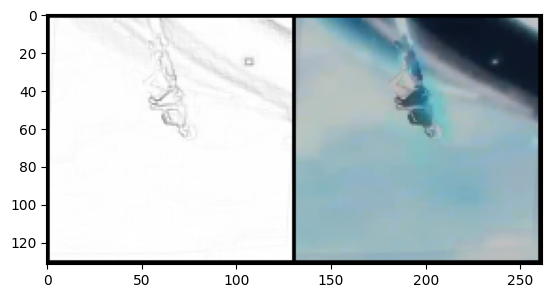

In [29]:
params = paramsSetting()

if 1:
    for i in params["test_loader"]:
        a, b = i
        break
    params["writer"].add_graph(params["model"], a)
    print(a.size())
    MyUtil.show_tensor(torchvision.utils.make_grid(torch.cat([a, b])))

In [7]:
teat = MyUtil.Report(params)
teat.display()
params["writer"].add_text(tag="discription", text_string=teat.RowMD)
del teat

In [10]:


traindModel_1 = trainer(params)
traindModel_1.train()


train:   0%|          | 0/72 [00:00<?, ?it/s]

停止を検知しました
1671020358_LatestModel.pthに保存しました。
